# QField integration into machine learning landcover classification within Digital Earth Pacific.

The following notebook is divide into 3 main parts : 
1. Data Preparation : define the Area Of Interest (AOI), load the data from Digital Earth Pacific Catalog and Interpolate on data points;
2. Model Training/Validation : build a random forest classifier, split the data into training, validation and testing, train the model and fine-tuning;
3. Visualize the prediction : show predictions from the training/validation

Follow the notebook, fill the missing code!

### Import Required Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client as DaskClient
from odc.geo.geom import BoundingBox
from odc.geo.geobox import GeoBox
from odc.stac import configure_s3_access, load
from pystac_client import Client

import requests
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
# Configure S3 access in Dask and outside
configure_s3_access(aws_unsigned=True)

# Set up a Dask client
dask_client = DaskClient(
    n_workers=2,
    threads_per_worker=16,
    memory_limit="30GB",
)

### Import Data Catalog

The Element 84 Earth Search catalog is an open STAC (SpatioTemporal Asset Catalog) API hosted on AWS (Amazon Web Services, cloudplatform) that provides access to satellite imagery, including Sentinel-2, Landsat, and other public Earth observation datasets.

In [3]:
catalog = "https://earth-search.aws.element84.com/v1/"
client = Client.open(catalog)

# Print all collections
response = requests.get(f"{catalog}collections")
collections = response.json()
for c in collections["collections"]:
    print(c["id"])

sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


## 1. Data Preparation 

In this part, first the AOI is define and then the following data are loaded: 
- Sentinel-2
- Spectral Indexes (NDVI, NDBI)
- Sentinel 1 
- Elevation Model
Finally, all the data are merge into one multiband dataset. This dataset is interpolated on label data point.

The label data point were downloaded from a shapefile from LRIS Portal (https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/services/tiles/) and process/adapt using QGIS to fit our need. From polygon of land cover classification, we categorise landcover within four classes : 
1. Forest
2. Settlement
3. Water
4. Grassland/Shrubland

The loaded data are interpolated based on 'nearest' over the label point. 

### Area Of Interest (AOI)

Define the coordinates of the box over the area we want to analyze. 

In [4]:
bbox = BoundingBox(left=174.72, bottom=-36.88, right=174.79, top=-36.8)
bbox.explore()

### Sentinel-2 Data

Sentinel-2 is a land monitoring constellation of two satellites that provide high resolution optical imagery. The mission provides a global coverage of the Earth's land surface every 5 days (8 days in the Pacific) L2A data are available from November 2016 over Europe region and globally since January 2017. It is composed of 13 bands: 4 visible bands, 6 Near-Infrared bands, and 3 Short-Wave Infrared bands. For the workshop purpose, we load only the data from 2024 and the RGB band + NIR and SwIR, which would be useful later. 

The median over all the data from 2024 is realised to simplify (we don't need a temporal analysis). Plus, it helps to mask the cloud, which are one of the biggest issue when working with spectral data, even more in the Pacific where tropical weather can be associated with cloudy weather. 

In [5]:
items = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024",
).item_collection()

# Load the data
chunks = dict(x=2048, y=2048)
geom = GeoBox.from_bbox(bbox, crs="EPSG:4326", resolution=0.0001)
data = load(
    items,
    chunks=chunks,
    like=geom,
    groupby="solar_day",
    measurements=[ "red", "blue", "green", "nir08", "swir16", "scl"],
)

# define scl classes
scl_included_classes = [4, 5, 6, 7]

low_cloud = data.scl.isin(scl_included_classes)
data_masked = data.where(low_cloud)

spectral = data_masked.median(dim="time")

spectral = spectral.expand_dims("time")
spectral = spectral.assign_coords(time=[pd.Timestamp("2024-01-01")])

print(spectral)

<xarray.Dataset> Size: 13MB
Dimensions:      (time: 1, latitude: 800, longitude: 700)
Coordinates:
  * latitude     (latitude) float64 6kB -36.8 -36.8 -36.8 ... -36.88 -36.88
  * longitude    (longitude) float64 6kB 174.7 174.7 174.7 ... 174.8 174.8 174.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    red          (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), meta=np.ndarray>
    blue         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), meta=np.ndarray>
    green        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), meta=np.ndarray>
    nir08        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), meta=np.ndarray>
    swir16       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), meta=np.ndarray>
    scl          (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 724, 634), m

In [6]:
spectral.red.odc.explore()

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


### Vegetation and Built-up Index

Spectral indexes are really useful to highlight specific pattern. There is a wide range of spectral indexes : water, wildfire, vegetation, building... In this workshop, we only present two of them that might help to highlight specific pattern in Auckland. 

The Normalized Difference Vegetation Index (**NDVI**) allows us to discriminate between vegetated and non-vegetated areas.  
It is calculated using the **near-infrared (NIR)** and **red** spectral bands as follows:

$$NDVI = \frac{NIR - RED}{NIR + RED}$$

- High NDVI values (close to +1) correspond to **dense, healthy vegetation**.  
- Low or negative NDVI values indicate **bare soil, built-up areas, or water**.

Then, The Normalized Difference Built-up Index (**NDBI**) highlights built-up or impervious surfaces such as buildings and roads.  
It uses the **short-wave infrared (SWIR)** and **near-infrared (NIR)** bands:
  
$$NDBI = \frac{SWIR - NIR}{SWIR + NIR}$$    
  
- High NDBI values represent **urban or built-up areas**.  
- Low values often correspond to **vegetation or water bodies**.


In [7]:
def add_indices(data: xr.Dataset) -> xr.Dataset:
    """
    Add common spectral indices to a Sentinel-2 xarray Dataset.
    Works with bands: red, green, blue, nir08, swir16.
    """
    spectral_bands = data[["red", "green", "blue", "nir08", "swir16"]]
    nodata = spectral_bands.red == 0

    # Do index calculation on scaled float values
    scaled = (spectral_bands / 10000).clip(0, 1).astype("float32")
    scaled = scaled.where(~nodata, np.nan)

    # NDVI = (NIR - Red) / (NIR + Red)
    data["ndvi"] = (scaled["nir08"] - scaled["red"]) / (scaled["nir08"] + scaled["red"])

    # NDBI (Normalized Difference Built-up Index) = (SWIR - NIR) / (SWIR + NIR)
    data["ndbi"] = (scaled["swir16"] - scaled["nir08"]) / (scaled["swir16"] + scaled["nir08"])

 
    del scaled

    return data

In [8]:
spectral_with_indices = add_indices(spectral).compute()
spectral_with_indices = spectral_with_indices.rename({
    "latitude": "y",
    "longitude": "x"
})
spectral_with_indices

<xarray.Dataset> Size: 18MB
Dimensions:      (time: 1, y: 800, x: 700)
Coordinates:
  * y            (y) float64 6kB -36.8 -36.8 -36.8 ... -36.88 -36.88 -36.88
  * x            (x) float64 6kB 174.7 174.7 174.7 174.7 ... 174.8 174.8 174.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    red          (time, y, x) float32 2MB 648.0 580.0 588.0 ... 483.0 383.0
    blue         (time, y, x) float32 2MB 714.0 614.0 498.0 ... 421.0 359.0
    green        (time, y, x) float32 2MB 836.0 758.0 662.0 ... 496.0 491.0
    nir08        (time, y, x) float32 2MB 2.274e+03 2.405e+03 ... 2.048e+03
    swir16       (time, y, x) float32 2MB 1.521e+03 1.764e+03 ... 1.293e+03
    scl          (time, y, x) float32 2MB 4.0 4.0 4.0 4.0 ... 5.0 5.0 4.0 4.0
    ndvi         (time, y, x) float32 2MB 0.5565 0.6114 0.6071 ... 0.6183 0.6849
    ndbi         (time, y, x) float32 2MB -0.1984 -0.1538 ... -0.226 -0.226

In [9]:
spectral_with_indices.ndvi.odc.explore(cmap="RdYlGn")

### Sentinel-1 

The Sentinel-1 mission comprises a constellation of two polar-orbiting satellites, operating day and night. Sentinel-1 carries a Synthetic Aperture Radar (SAR) which has the advantage of operating at wavelengths that are not affected by cloud cover or lack of illumination, allowing it to acquire data over a site during both day and night time, and under all weather conditions. The C-SAR instrument of Sentinel-1 provides reliable and repeated wide area monitoring. Sentinel-1 offers dual polarization capability (vv & vh), very short revisit times, and rapid product delivery. Radar backscatter measures the amount of microwave radiation reflected back to the satellite from the ground surface. This measurement is sensitive to surface roughness, moisture content, and viewing geometry.

In [10]:
items = client.search(
    collections=["sentinel-1-grd"],
    bbox=bbox,
    datetime="2024",
).item_collection()

# Load the data
chunks = dict(x=2048, y=2048)
data = load(
    items,
    chunks=chunks,
    like=spectral_with_indices.odc.geobox,
    groupby="solar_day",
)

radar = data.median(dim="time").compute()

radar = radar.expand_dims("time")
radar = radar.assign_coords(time=[pd.Timestamp("2024-01-01")])

radar = radar.rename({
    "latitude": "y",
    "longitude": "x"
})

print(radar)

<xarray.Dataset> Size: 9MB
Dimensions:      (y: 800, x: 700, time: 1)
Coordinates:
  * y            (y) float64 6kB -36.8 -36.8 -36.8 ... -36.88 -36.88 -36.88
  * x            (x) float64 6kB 174.7 174.7 174.7 174.7 ... 174.8 174.8 174.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    vh           (time, y, x) float64 4MB 67.0 65.5 65.0 ... 151.0 124.5 135.0
    vv           (time, y, x) float64 4MB 118.0 142.5 161.0 ... 240.0 247.0


In [11]:
radar.vv.odc.explore()

### Elevation Model

The elevation model available through the Element 84 catalog provides global terrain data (such as surface elevation) derived from sources like the Copernicus DEM or NASA’s SRTM. It represents the Earth's surface height in meters and can be used for topographic analysis and environmental modeling.

In [12]:
e84_catalog = "https://earth-search.aws.element84.com/v1/"
dem_collection = "cop-dem-glo-30"
e84_client = Client.open(e84_catalog)

dem_items = e84_client.search(
    collections=[dem_collection],
    bbox=bbox
).item_collection()

dem_data = load(
    items=dem_items,
    like=spectral_with_indices.odc.geobox
)
dem_data = dem_data.rename({
    "latitude": "y",
    "longitude": "x"
})
dem_data

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 800, x: 700, time: 1)
Coordinates:
  * y            (y) float64 6kB -36.8 -36.8 -36.8 ... -36.88 -36.88 -36.88
  * x            (x) float64 6kB 174.7 174.7 174.7 174.7 ... 174.8 174.8 174.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2021-04-22
Data variables:
    data         (time, y, x) float32 2MB 90.46 91.3 91.3 ... 90.75 90.75 94.5

In [13]:
dem_data.data.odc.explore()

### Interpolation of Data on Label Points

Now that all the different types of data are loaded, we need to merge them into a single dataset containing all the bands (Sentinel-1, Sentinel-2, NDVI, NDBI, and elevation). Once merged, we can interpolate the data onto the label points using the nearest method. This means that each label point will be assigned one value for each band, corresponding to the value of the nearest pixel in the dataset.

In [14]:
# Concat all the data into one dataset 
spectral_with_indices = spectral_with_indices.squeeze("time", drop=True)
dem_data = dem_data.squeeze("time", drop=True)
radar = radar.squeeze("time", drop=True)

final_data = xr.merge([spectral_with_indices, radar, dem_data])
final_data = final_data.rename({
    "data": "dem"
})
final_data

<xarray.Dataset> Size: 29MB
Dimensions:      (y: 800, x: 700)
Coordinates:
  * y            (y) float64 6kB -36.8 -36.8 -36.8 ... -36.88 -36.88 -36.88
  * x            (x) float64 6kB 174.7 174.7 174.7 174.7 ... 174.8 174.8 174.8
    spatial_ref  int32 4B 4326
Data variables:
    red          (y, x) float32 2MB 648.0 580.0 588.0 ... 568.0 483.0 383.0
    blue         (y, x) float32 2MB 714.0 614.0 498.0 ... 480.0 421.0 359.0
    green        (y, x) float32 2MB 836.0 758.0 662.0 ... 598.0 496.0 491.0
    nir08        (y, x) float32 2MB 2.274e+03 2.405e+03 ... 2.048e+03 2.048e+03
    swir16       (y, x) float32 2MB 1.521e+03 1.764e+03 ... 1.293e+03 1.293e+03
    scl          (y, x) float32 2MB 4.0 4.0 4.0 4.0 4.0 ... 5.0 5.0 5.0 4.0 4.0
    ndvi         (y, x) float32 2MB 0.5565 0.6114 0.6071 ... 0.518 0.6183 0.6849
    ndbi         (y, x) float32 2MB -0.1984 -0.1538 -0.1538 ... -0.226 -0.226
    vh           (y, x) float64 4MB 67.0 65.5 65.0 65.0 ... 151.0 124.5 135.0
    vv           (y, x) float64 4MB 118.0 142.5 161.0 ... 233.0 240.0 247.0
    dem          (y, x) float32 2MB 90.46 91.3 91.3 91.3 ... 90.75 90.75 94.5

In [15]:
# Open Points File 
gdf = gpd.read_file("lulc_auckland_v3.gpkg").to_crs(final_data.odc.crs)
gdf.explore()

In [16]:
# Interpolation of Final Dataset on Label Point
sampled = final_data.interp(
    x=("points", gdf.geometry.x.values),
    y=("points", gdf.geometry.y.values),
    method="nearest"
)


# Clean the dataset 
df = sampled.to_dataframe().reset_index(drop=True)

df["Class_id"] = gdf["Class_id"].values 
df["Land_Cover"] = gdf["Land_Cover"].values
df = df.drop(["spatial_ref"], axis=1)

df = df.groupby("Class_id", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))

print(f'Number of points : {len(df)}')
df.head()

Number of points : 326


/tmp/ipykernel_1743/3656657539.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Class_id", group_keys=False).apply(lambda g: g.fillna(g.mean(numeric_only=True)))


red    blue   green   nir08  swir16  scl      ndvi      ndbi     vh  \
0   709.5   630.0   807.0  2010.0  1569.0  5.0  0.478213 -0.123219  148.0   
1   551.0   498.5   659.5  1924.5  1319.5  4.0  0.554837 -0.186498  114.5   
2   692.0   786.0   701.0  1404.0  1581.0  5.0  0.339695  0.059296  156.5   
3  1916.0  1731.0  1902.0  2752.0  3043.0  5.0  0.179092  0.050216   96.5   
4   904.0   796.0   852.0  2057.0  1673.0  5.0  0.389395 -0.102949  132.5   

      vv        dem           x          y  Class_id Land_Cover  
0  314.5  50.611740  174.744191 -36.846284         2   Built-up  
1  202.5  60.702251  174.752023 -36.869010         2   Built-up  
2  308.0  43.440605  174.779012 -36.853080         2   Built-up  
3  515.0  61.118668  174.779039 -36.868621         2   Built-up  
4  222.0  72.069717  174.781719 -36.871848         2   Built-up

## 2. Model Training  

Random Forest is a supervised machine learning algorithm commonly used. It works by building an ensemble of decision trees (called estimators). Each tree is trained on a random subset of the data and features (bands), and the final prediction is made by combining the outputs of all trees. This ensemble approach reduces overfitting and improves generalization. In land cover classification, each pixel is assigned a land cover class (forest/tree, water, builup, urban park) based on its spectral and derived indices.

To evaluate the performance of the model, several metrics are commonly used: 

- Accuracy: The proportion of correctly classified samples among all samples.
- F1-score: The harmonic mean of precision and recall, useful when classes are imbalanced.
- Kappa coefficient (Cohen’s Kappa): Measures the agreement between predicted and true labels while accounting for the agreement that could occur by chance.

Together, these metrics provide a comprehensive view of how well the model performs in distinguishing different land cover types.

In [17]:
counts = df["Land_Cover"].value_counts().T
counts

Land_Cover
Built-up       100
Urban Park     100
Forest/Tree     96
Water           30
Name: count, dtype: int64

In [18]:
print(f'Possible features for training :\n {df.columns.values[:-4]}')

Possible features for training :
 ['red' 'blue' 'green' 'nir08' 'swir16' 'scl' 'ndvi' 'ndbi' 'vh' 'vv' 'dem']


In [19]:
# Select Features and Labels 
features = df[['red', 'blue', 'green', 'nir08', 'swir16', 'ndvi', 'ndbi', 'vh', 'vv', 'dem']]

labels = df['Class_id']


# Split Data between training/validation/testing 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.20, random_state=42)

In [20]:
# Train Random Forest Classifier 
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight='balanced')

rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)

Random Forest Classifier Performance
Accuracy: 74.24%
Weighted F1-score: 74.21%
Cohen's Kappa: 0.642

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.79      0.70        19
           2       0.82      0.61      0.70        23
           3       1.00      1.00      1.00         6
           4       0.74      0.78      0.76        18

    accuracy                           0.74        66
   macro avg       0.80      0.79      0.79        66
weighted avg       0.76      0.74      0.74        66



In [21]:
# PREDICTIONS
train_features = ['red', 'blue', 'green', 'nir08', 'swir16', 'ndvi', 'ndbi', 'vh', 'vv', 'dem']
datasets = final_data

missing_features = [f for f in train_features if f not in datasets.data_vars]
if missing_features:
    raise ValueError(f"Missing features in the dataset: {missing_features}")

stacked = np.stack([np.squeeze(datasets[f].values) for f in train_features], axis=0)
bands, ysize, xsize = stacked.shape
X_test = stacked.reshape(bands, -1).T 

# Create Prediction Mask 
valid_mask = np.all(np.isfinite(X_test), axis=1)
X_valid = X_test[valid_mask]

# Predict only on valid pixels
pred_flat = np.full(X_test.shape[0], np.nan) 
pred_flat[valid_mask] = rf.predict(X_valid)  

# Reshape back 
pred_raster = pred_flat.reshape(ysize, xsize)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
  Feature  Importance
4  swir16    0.197119
9     dem    0.153400
3   nir08    0.130661
6    ndbi    0.105813
5    ndvi    0.104540
1    blue    0.085200
0     red    0.075383
2   green    0.058029
8      vv    0.047731
7      vh    0.042123


## 3. Visualize Prediction

In [23]:
red = datasets["red"].astype("float32")
green = datasets["green"].astype("float32")
blue = datasets["blue"].astype("float32")

rgb = np.stack([red, green, blue], axis=-1)
rgb_norm = np.clip(rgb / np.percentile(rgb, 99), 0, 1)

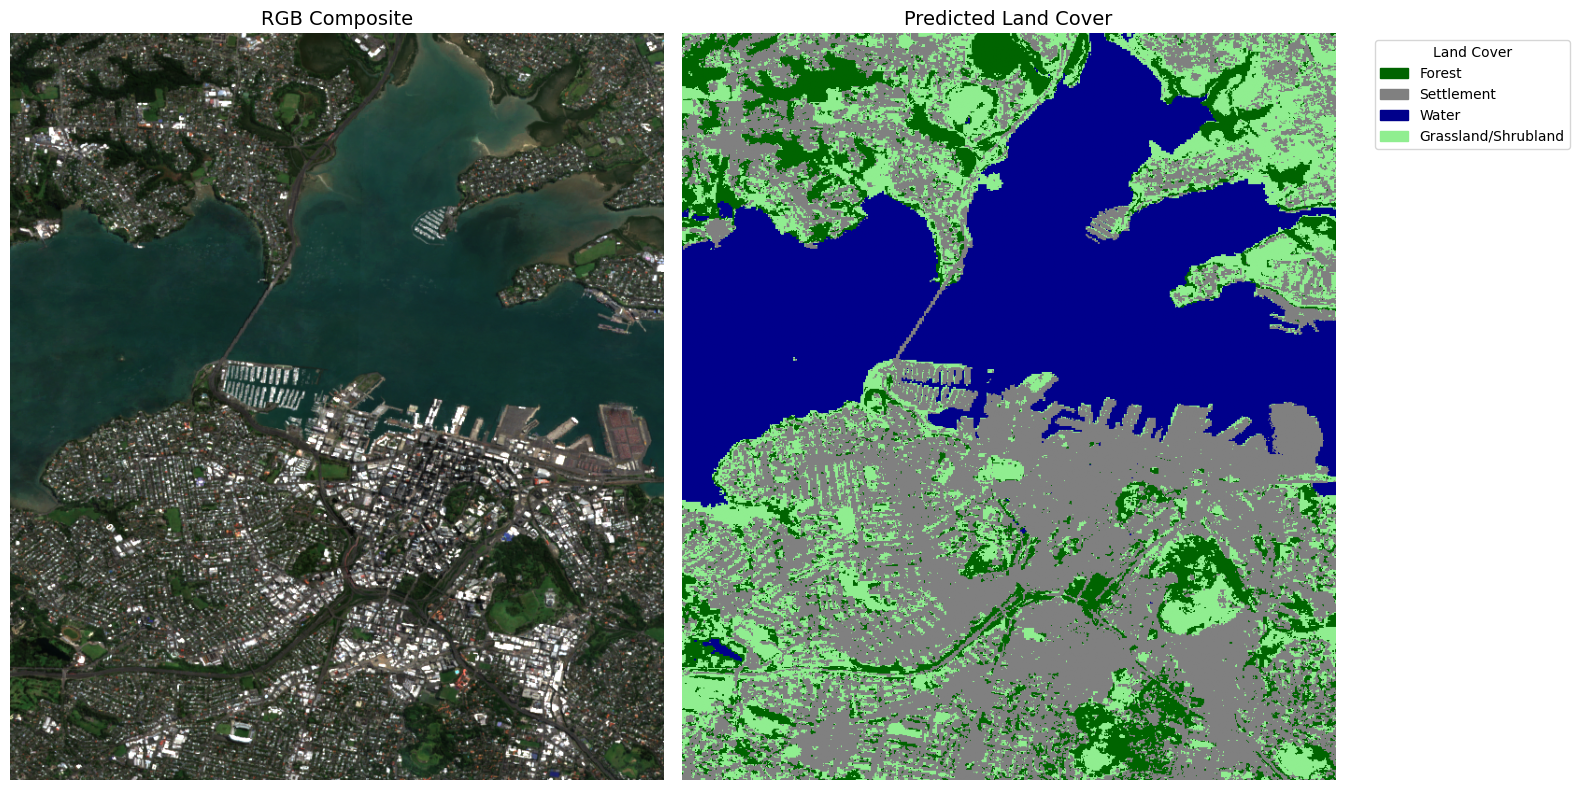

In [24]:
# Define class labels and colors
class_labels = {
    1: "Forest",
    2: "Settlement",
    3: "Water",
    4: "Grassland/Shrubland"
}

colors = [
    "darkgreen",  # Forest/Tree
    "grey",      # Build up
    "darkblue",  # Water
    "lightgreen"  # Urban Park
]

cmap = ListedColormap(colors)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: RGB composite
axes[0].imshow(rgb_norm)
axes[0].set_title("RGB Composite", fontsize=14)
axes[0].axis("off")

# Right: Prediction
im = axes[1].imshow(pred_raster, cmap=cmap)
axes[1].set_title("Predicted Land Cover", fontsize=14)
axes[1].axis("off")

# Legend on right
patches = [Patch(color=colors[i-1], label=class_labels[i]) for i in class_labels]
axes[1].legend(
    handles=patches,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Land Cover",
    fontsize=10
)

plt.tight_layout()
plt.show()